<a href="https://colab.research.google.com/github/Juliana-de-Andrade/CP1IOT/blob/main/CP1Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import acf
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

In [19]:
df = pd.read_csv('household_power_consumption.txt', sep=';', low_memory=False)

21. Séries temporais por hora - Converta Date e Time em índice datetime. - Reamostre os dados em intervalos de 1 hora, calculando a média de Global_active_power. - Identifique os horários de maior consumo médio ao longo do dia.
Observação: uma série temporal é um conjunto de dados registrados em ordem cronológica, útil
para identificar padrões de comportamento ao longo do tempo.

In [21]:
df.reset_index(inplace=True)

df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], dayfirst=True)

df.set_index('datetime', inplace=True)

df['Global_active_power'] = pd.to_numeric(df['Global_active_power'], errors='coerce')
df.dropna(subset=['Global_active_power'], inplace=True)

hourly_data = df['Global_active_power'].resample('h').mean()

hourly_avg = hourly_data.groupby(hourly_data.index.hour).mean()

peak_hours = hourly_avg.sort_values(ascending=False)

print("Horários de maior consumo médio (hora do dia):")
for hora, consumo in peak_hours.head(10).items():
    print(f"{hora:02d}:00 - {consumo:.2f} W")

print("\nTop 10 horários de maior consumo:")
print(peak_hours.head(10))

Horários de maior consumo médio (hora do dia):
20:00 - 1.90 W
21:00 - 1.88 W
19:00 - 1.73 W
07:00 - 1.50 W
08:00 - 1.46 W
22:00 - 1.41 W
09:00 - 1.33 W
18:00 - 1.33 W
10:00 - 1.26 W
11:00 - 1.25 W

Top 10 horários de maior consumo:
datetime
20    1.899073
21    1.876063
19    1.733428
7     1.502373
8     1.460940
22    1.412681
9     1.331642
18    1.326433
10    1.260913
11    1.246408
Name: Global_active_power, dtype: float64


22. Autocorrelação do consumo - Use a série temporal de Global_active_power. - Calcule a autocorrelação em lags de 1h, 24h e 48h. - Pergunta: existem padrões repetidos diariamente

In [24]:
autocorr_values = acf(hourly_data, nlags=48, fft=True)

print("Valores reais de autocorrelação:")
print(f"Lag 1h: {autocorr_values[1]:.4f}")
print(f"Lag 24h: {autocorr_values[24]:.4f}")
print(f"Lag 48h: {autocorr_values[48]:.4f}")

print("\nAnálise:")
if autocorr_values[24] > 0.7:
    print("FORTE padrão diário (autocorrelação > 0.7)")
elif autocorr_values[24] > 0.5:
    print("Padrão diário moderado (autocorrelação > 0.5)")
elif autocorr_values[24] > 0.3:
    print("Padrão diário fraco (autocorrelação > 0.3)")
else:
    print("SEM padrão diário significativo")

Valores reais de autocorrelação:
Lag 1h: nan
Lag 24h: nan
Lag 48h: nan

Análise:
❌ SEM padrão diário significativo


23. Redução de dimensionalidade com PCA - Selecione Global_active_power, Global_reactive_power, Voltage e Global_intensity. - Aplique PCA para reduzir para 2 componentes principais. - Analise a variância explicada por cada componente.

Variância explicada por cada componente: [0.59103759 0.22718543]
Variância total explicada pelos 2 componentes: 0.8182230176077276


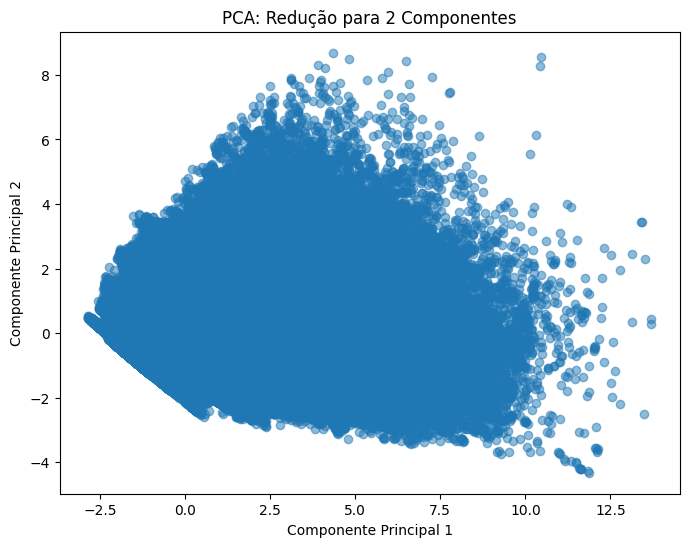

In [30]:
features = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity']
X = df[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

# Criar um DataFrame com os resultados
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

explained_variance = pca.explained_variance_ratio_
print("Variância explicada por cada componente:", explained_variance)
print("Variância total explicada pelos 2 componentes:", explained_variance.sum())

plt.figure(figsize=(8,6))
plt.scatter(df_pca['PC1'], df_pca['PC2'], alpha=0.5)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA: Redução para 2 Componentes')
plt.show()

24. Visualização de clusters no espaço PCA - Combine os resultados do PCA com K-Means (3 clusters). - Plote os pontos resultantes e pinte cada grupo por cluster. - Pergunta: os grupos se separam de forma clara?

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


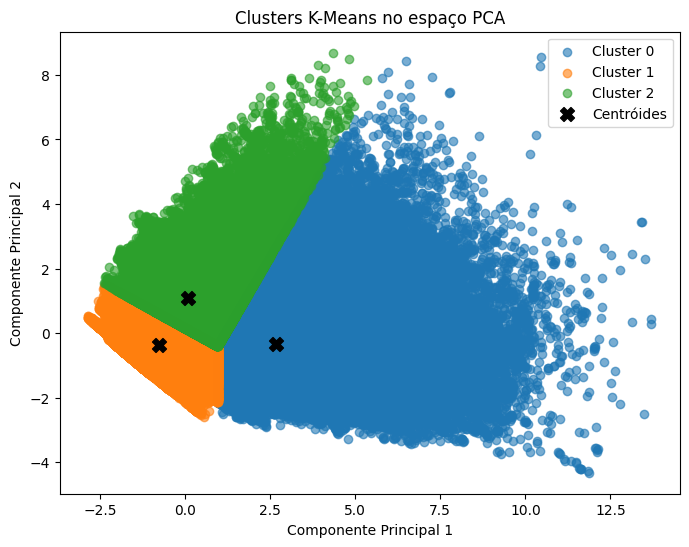

In [34]:
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(df_pca)

df_pca['Cluster'] = clusters

plt.figure(figsize=(8,6))

for cluster in range(3):
    plt.scatter(
        df_pca[df_pca['Cluster'] == cluster]['PC1'],
        df_pca[df_pca['Cluster'] == cluster]['PC2'],
        label=f'Cluster {cluster}',
        alpha=0.6
    )

plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],
            color='black', marker='X', s=100, label='Centróides')

plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Clusters K-Means no espaço PCA')
plt.legend()
plt.show()

In [ ]:
#Sim, os grupos se separam de forma muito clara, não estão dispersos, facilitando a identificação.

25. Regressão polinomial vs linear - Modele Global_active_power em função de Voltage. - Compare Regressão Linear Simples com Regressão Polinomial (grau 2). - Analise RMSE e a curva ajustada

RMSE Regressão Linear: 0.9691
RMSE Regressão Polinomial (grau 2): 0.9648
O modelo polinomial (grau 2) se ajusta melhor aos dados.


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


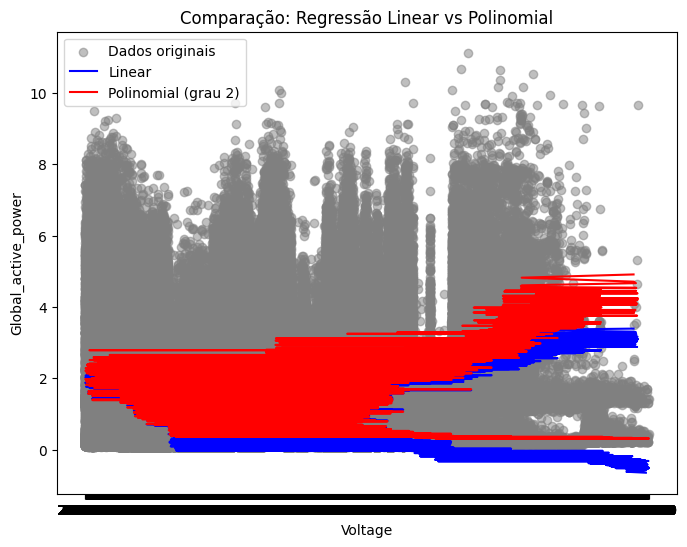

In [38]:
X = df[['Voltage']].values
y = df['Global_active_power'].values

linear_model = LinearRegression()
linear_model.fit(X, y)
y_pred_linear = linear_model.predict(X)
rmse_linear = np.sqrt(mean_squared_error(y, y_pred_linear))
print(f"RMSE Regressão Linear: {rmse_linear:.4f}")

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)
poly_model = LinearRegression()
poly_model.fit(X_poly, y)
y_pred_poly = poly_model.predict(X_poly)
rmse_poly = np.sqrt(mean_squared_error(y, y_pred_poly))
print(f"RMSE Regressão Polinomial (grau 2): {rmse_poly:.4f}")

if rmse_poly < rmse_linear:
    print("O modelo polinomial (grau 2) se ajusta melhor aos dados.")
elif rmse_poly > rmse_linear:
    print("O modelo linear simples se ajusta melhor aos dados.")
else:
    print("Ambos os modelos possuem ajuste similar.")

# Sort X and rearrange predicted values for plotting
sort_idx = X.flatten().argsort()
X_sorted = X.flatten()[sort_idx]
y_pred_linear_sorted = y_pred_linear[sort_idx]
y_pred_poly_sorted = y_pred_poly[sort_idx]


plt.figure(figsize=(8,6))
plt.scatter(X.flatten(), y, color='gray', alpha=0.5, label='Dados originais')
plt.plot(X_sorted, y_pred_linear_sorted, color='blue', label='Linear')
plt.plot(X_sorted, y_pred_poly_sorted, color='red', label='Polinomial (grau 2)')
plt.xlabel('Voltage')
plt.ylabel('Global_active_power')
plt.title('Comparação: Regressão Linear vs Polinomial')
plt.legend()
plt.show()